In [1]:
!pip install transformers[sentencepiece] -Uqq
!pip install datasets -Uqq

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 22.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 50.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.0 MB/s eta 0:00:00


In [2]:
!pip install transformers[torch] accelerate -Uqq

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.7/265.7 kB 4.6 MB/s eta 0:00:00


In [28]:
import html
import re
import pandas as pd
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from transformers import Trainer, TrainingArguments

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from datasets import load_dataset
from datasets import load_metric

In [5]:
data_files = {"train": "spam-train.csv", "valid": "spam-valid.csv", "validation":"spam-test.csv"}
raw_datasets = load_dataset('csv', data_files=data_files)

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating valid split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

In [6]:
raw_datasets

DatasetDict({
    train: Dataset({
        features: ['snippet', 'label'],
        num_rows: 770
    })
    valid: Dataset({
        features: ['snippet', 'label'],
        num_rows: 60
    })
    validation: Dataset({
        features: ['snippet', 'label'],
        num_rows: 100
    })
})

In [7]:
def remove_zwnj(text):
    return re.sub('\u200c', '', text)

raw_datasets = raw_datasets.filter(lambda x: x["snippet"] is not None)
raw_datasets = raw_datasets.map(lambda x: {"snippet": html.unescape(x["snippet"])})
raw_datasets = raw_datasets.map(lambda x: {"snippet": remove_zwnj(x["snippet"])})

Filter:   0%|          | 0/770 [00:00<?, ? examples/s]

Filter:   0%|          | 0/60 [00:00<?, ? examples/s]

Filter:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:   0%|          | 0/767 [00:00<?, ? examples/s]

Map:   0%|          | 0/60 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:   0%|          | 0/767 [00:00<?, ? examples/s]

Map:   0%|          | 0/60 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

In [8]:
checkpoint = "distilbert-base-uncased-finetuned-sst-2-english"

tokenizer = AutoTokenizer.from_pretrained(checkpoint)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

In [9]:
def tokenize_function(example):
  return tokenizer(
      example['snippet'],
      truncation=True,
      padding="max_length")

tokenized_datasets = raw_datasets.map(tokenize_function, batched=True)

Map:   0%|          | 0/767 [00:00<?, ? examples/s]

Map:   0%|          | 0/60 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

In [10]:
tokenized_datasets.column_names

{'train': ['snippet', 'label', 'input_ids', 'attention_mask'],
 'valid': ['snippet', 'label', 'input_ids', 'attention_mask'],
 'validation': ['snippet', 'label', 'input_ids', 'attention_mask']}

In [11]:
#tokenized_datasets = tokenized_datasets.remove_columns(['date', 'sender'])
#tokenized_datasets = tokenized_datasets.rename_column('label', 'labels')
tokenized_datasets = tokenized_datasets.with_format("torch")

In [12]:
metric = load_metric("glue", "mrpc")

def compute_metrics(eval_preds):
  logits, labels = eval_preds
  predictions = np.argmax(logits, axis=-1)
  return metric.compute(predictions=predictions, references=labels)

training_args = TrainingArguments("test-trainer", evaluation_strategy="epoch")
model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=2)

trainer = Trainer(
    model,
    training_args,
    train_dataset=tokenized_datasets['train'],
    eval_dataset=tokenized_datasets['valid'],
    compute_metrics=compute_metrics
)

trainer.train()

<ipython-input-12-c8a10212d510>:1: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("glue", "mrpc")


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.349708,0.866667,0.920000
2,No log,0.242901,0.916667,0.952381
3,No log,0.358736,0.900000,0.942308


TrainOutput(global_step=288, training_loss=0.2633354134029812, metrics={'train_runtime': 107.1561, 'train_samples_per_second': 21.473, 'train_steps_per_second': 2.688, 'total_flos': 304807484307456.0, 'train_loss': 0.2633354134029812, 'epoch': 3.0})

In [13]:
# view output shape
predictions = trainer.predict(tokenized_datasets["validation"])
print(predictions.predictions.shape, predictions.label_ids.shape)

(100, 2) (100,)


In [14]:
# view model performance on test set
metric = load_metric("glue", "mrpc")
preds = np.argmax(predictions.predictions, axis=-1)
metric.compute(predictions=preds, references=predictions.label_ids)

{'accuracy': 0.86, 'f1': 0.8444444444444444}

In [23]:
df = pd.DataFrame({"preds": preds, "actual":raw_datasets['validation']['label']})

In [27]:
df[df['preds'] == df['actual']].shape

(86, 2)

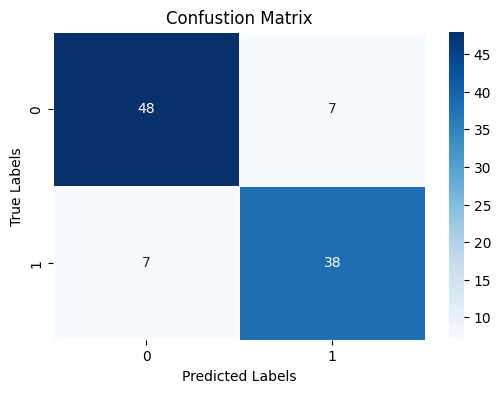

In [30]:
conf_matrix = confusion_matrix(df['preds'], df['actual'])
plt.figure(figsize=(6,4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", linewidths=.5)
plt.title("Confustion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.savefig("nlp-conf.png")

In [33]:
classification_rep = classification_report(df['actual'], df['preds'])
print(f'Classification Report:\n{classification_rep}')

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.87      0.87        55
           1       0.84      0.84      0.84        45

    accuracy                           0.86       100
   macro avg       0.86      0.86      0.86       100
weighted avg       0.86      0.86      0.86       100

